In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta

In [2]:
df_master = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [3]:
df_master.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [4]:
df_master.shape

(200853, 6)

In [5]:
import collections

In [30]:
!pip install spacy
!python -m spacy download en

You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/en_core_web_sm
-->
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [6]:
import spacy
from nltk.util import ngrams
import re, collections

nlp = spacy.load('en')

def sent_lem(sent):
    
    #Lemmatize and remove stop words
    sent = nlp(sent.lower())
    
    words = [token.lemma_ for token in sent if not token.is_stop]
    
    #Join words separate by spaces
    sent = ' '.join(words)
    
    #Remove non-alphabetical letters        
    alpha_only = re.sub("[^a-zA-Z ]", '', sent)

    return(alpha_only)

In [7]:
#Generate ngrams from the text
def get_ngram(txt, n):
    tokenized = txt.split()
    _ngrams = ngrams(tokenized, n)
    return(_ngrams)

#Introduce potential label functions
def potential_lfs(df, l_index, ngram, topn): #one class(l_index) at a time
    text = ' '.join(df[df['Label'] == labels[l_index]]['Lem Content'])
    tokenized = text.split()
    esBigrams = ngrams(tokenized, ngram)
    
    # get the frequency of each bigram in our corpus
    esBigramFreq = collections.Counter(esBigrams)
    #Select top n occured ngrams
    return [list(x[0]) for x in esBigramFreq.most_common(topn)]
    
#"The Label Function filter"
def get_new_lfs(df, numoflabels, ngram, topn):
    pot_lfs = []
    for i in range(0,numoflabels):
        pot_lfs.append(potential_lfs(df, i, ngram, topn))
        
    pot_lfs_aggr = sum(pot_lfs, [])
    
    new_lfs = []
    
    for j, _class in enumerate(pot_lfs):
        _class_new = []
        for lf in _class:
            if (pot_lfs_aggr.count(lf) == 1) and (not str(lf) in LF_dict) and (not str(lf) in Bad_dict) and (sum(len(c) == 1 for c in lf) != 2):
                _class_new.append(lf)
        new_lfs.append(_class_new)
        
    return new_lfs

In [8]:
#The indicator for the first LF in class 2 is: 2_1
#The master(class) indicator for 2_1 is 2.

def check_overlap_helper(lst, indicator):
    return (indicator in lst) and (len(lst) >= 2) and (sum(k[0] == indicator[0] for k in lst) == len(lst))

def check_conflict_helper(lst, indicator):
    return (indicator in lst) and (sum(indicator[0] != k[0] for k in lst) >= 1)

def check_master_overlap_helper(lst, master_indicator):
    return (sum(master_indicator == k[0] for k in lst) >= 1) and (sum(master_indicator != k[0] for k in lst) == 0)

def check_master_conflict_helper(lst, master_indicator):
    return (sum(master_indicator == k[0] for k in lst) >= 1) and (sum(master_indicator != k[0] for k in lst) >= 1)

In [9]:
def intersection(lst1, str2): #between a list of strings and a string
    matches = [s for s in lst1 if s in str2]
    return(matches)

def apply_lf(df, LFs):
#Applying Heuristics to sentences
#Dictionary of LF->Indicator:
    total_sent = df.shape[0] #total number of sentences
    for j in range(0, total_sent):
        if (type(df.iloc[j,2]) == str) and (len(df.iloc[j,2]) >= 1):
            continue
        LF_lst = []
        for l, label in enumerate(LFs):
            for i in range(0, len(label)):
                LF = label[i]
                LF_dict[str(LF)] = (str(l) + '_' + str(i))
                overlap_lst = intersection(LF, df.iloc[j,0])
                if sorted(overlap_lst) == sorted(LF):
                    #print(LF, overlap_lst)
                    LF_lst.append((str(l) + '_' + str(i)))
        if(len(LF_lst) == 1):
            df.iloc[j,2] = labels[int(LF_lst[0][0])]
        elif(len(LF_lst) >= 1):
            if check_overlap_helper(LF_lst, LF_lst[0]):
                df.iloc[j,2] = labels[int(LF_lst[0][0])]
            else:
                df.iloc[j,2] = 'Conflict' 
        else:
            df.iloc[j,2] = ''
        df.iloc[j,1] = LF_lst
    print(sum(len(k) >= 1 for k in df['Label']))
        
    return df, LF_dict

In [10]:
def update_Heur(Heur, LF_dict): #Remove bad LFs
    new_Heur = []
    for LFs in Heur:
        new_Heur.append([lf for lf in LFs if str(lf) in LF_dict])
    
    return new_Heur

In [11]:
def create_stats(df, LFs):    
    
    df_stat = pd.DataFrame(columns=['i','LF','Label','Coverage','Overlap (within Cov)','Conflict (within Cov)'])
    df_stat_master = pd.DataFrame(columns=['LF','Coverage','Overlap (within Cov)','Conflict (within Cov)'])

    lookup = df['LFs']

    n = 0
    for l, label in enumerate(LFs):
        master_label = 0
        for i in range(0, len(label)):
            indicator = str(l) + '_' + str(i)
            Total_Labelled_by_LF = sum(indicator in k for k in lookup)
            try:
                Coverage = sum((indicator in k) for k in lookup) / df.shape[0]
            except:
                Coverage = 0
            try:
                Overlap = sum(check_overlap_helper(k, indicator) for k in lookup) / Total_Labelled_by_LF
            except:
                Overlap = 0
            try:
                Conflict = sum(check_conflict_helper(k, indicator) for k in lookup) / Total_Labelled_by_LF
            except:
                Conflict = 0
            df_stat.loc[n] = [indicator, str(label[i]), labels[l], str(round(Coverage,4)), str(round(Overlap,4)), str(round(Conflict,4))] #list of multiple types
            n += 1
            master_label += Total_Labelled_by_LF
        master_Cov = master_label / df.shape[0]
        try:
            master_Ov = sum(check_master_overlap_helper(k, str(l)) for k in lookup) / master_label
        except:
            master_Ov = 0
        try:
            master_Conf = sum(check_master_conflict_helper(k, str(l)) for k in lookup) / master_label
        except:
            master_Conf = 0
        df_stat_master.loc[l] = [labels[l], str(round(master_Cov,4)), str(round(master_Ov,4)), str(round(master_Conf,4))]
        
    return df_stat_master, df_stat

In [12]:
def run(df_train, df_test, num_of_labels, ngram, num_of_ngram):


    #coverage = pd.DataFrame(columns=['Total Coverage', 'Correct Coverage'])

    #Bigrams -> LFs
    Heuristics = get_new_lfs(df_train, num_of_labels, ngram, num_of_ngram)

    df_test, LF_dict = apply_lf(df_test, Heuristics)
    epoch = 0
        
    while(True):
        epoch += 1
        df_stat_master, df_stat = create_stats(df_test, Heuristics)

        #Update Heuristics
        for i, row in df_stat.iterrows():
            #Solve >50% conflict for accuracy improvement.
            #print(epoch, list(row))
            if(row['Coverage'] == '0.0') or (row['Conflict (within Cov)'] >= '0.5'):
                if row['LF'] in LF_dict:
                    LF_dict.pop(row['LF'])
                    Bad_dict[row['LF']] = 1

        new_lfs = get_new_lfs(df_test, num_of_labels, ngram, num_of_ngram+5)

        if(sum(new_lfs, []) == []):
            break

        for i in range(0,num_of_labels):
            Heuristics[i] = new_lfs[i]

        #Run LF functions:

        df_test, LF_dict = apply_lf(df_test, Heuristics)

    Total = sum(len(k) >= 1 for k in df_test['Label'])
    Cor = (df_test[df_test['Label'] == df_test['Actual Label']].shape[0])
    #coverage.loc[n] = [Total, Cor]
        
    return Total, Cor, epoch

In [13]:
df_master['category'].shape

(200853,)

In [14]:
df = pd.DataFrame(columns=['Label', 'Content'])

df['Label'] = df_master['category']
df['Content'] = df_master['headline'] + ' ' + df_master['short_description']

df.head()

,Label,Content
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


In [15]:
#label_combs = [['TASTE','WORLD NEWS','SCIENCE','STYLE','RELIGON','WORLDPSOT'],['EDUCATION','CULTURE & ARTS','ENVIRONMENT','GOOD NEWS','FIFTY','TECH']]
#Test Run:
#label_combs = [['WORLD NEWS','TASTE']]
#label_combs = [['WOMEN','IMPACT','DIVORCE','CRIME']]
#Normal Run:
label_combs = [['WORLD NEWS','TASTE'],['TASTE','TECH'],['MONEY','ARTS'],['ARTS','FIFTY'],['FIFTY','GOOD NEWS'],['GOOD NEWS','ARTS & CULTURE'],['ARTS & CULTURE','ENVIRONMENT'],['ENVIRONMENT','COLLEGE'],['COLLEGE','LATINO VOICES'],['CULTURE & ARTS','EDUCATION']]

In [19]:
def get_data(df, labels):

    df = df[df['Label'].isin(labels)].reset_index()

    #Lemmatize Content Sentences
    df['Content'] = df['Content'].apply(sent_lem)

    X = df['Content']
    y = df['Label']
    
    return X, y

In [21]:
df_test_size = pd.DataFrame(columns=['Test Size','Labels','Labeled','Unlabeled','Total Coverage','Coverage Percentage','Correct Coverage','Correct Percentage','Coverage STD'])

i = 0

init_time = datetime.now()

for labels in label_combs:
        
    X, y = get_data(df, labels)
        
    #for test_size in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]:
    #for test_size in [0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]:
    for test_size in [0.95]:
        s_time = datetime.now().strftime('%H:%M:%S')

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

        df_train = pd.DataFrame(columns=['Label', 'Lem Content'])

        df_train['Lem Content'] = X_train
        df_train['Label'] = y_train
        df_train = df_train.groupby(df_train['Label']).sum().reset_index()

        
        df_test = pd.DataFrame(columns=['Lem Content','LFs','Label','Actual Label'])

        df_test['Lem Content'] = X_test
        df_test['Actual Label'] = y_test
        
        Bad_dict = {}
        LF_dict = {}
        num_of_labels = len(labels)

        Total, Cor, epoch = run(df_train, df_test, num_of_labels, 2, 5)

        new_labelled = list(df_test[df_test['Label'] != '']['Label'].value_counts())

        try:
            std = np.std(new_labelled) #std = sqrt(mean(abs(x - x.mean())**2)).
        except:
            std = 0

        try:
            CorrectCOV = Cor/Total
        except:
            CorrectCOV = 0

        df_test_size.loc[i] = [test_size,str(labels),len(X_train),len(X_test),Total,Total/len(y),Cor,CorrectCOV,std]

        e_time = datetime.now().strftime('%H:%M:%S')

        print("****",s_time," to ",e_time,"****",labels,"Test Size:",test_size,"Epochs:",epoch)
        i += 1

final_time = datetime.now()

print("Total Time: (in minute)", round((final_time - init_time)/timedelta(minutes=1),2))

    #plot progress graph per label selection combination

531
562
562
**** 21:50:11  to  21:50:27 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.8 Epochs: 3
377
411
420
**** 21:50:27  to  21:50:46 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.85 Epochs: 3
520
554
580
**** 21:50:46  to  21:51:06 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.9 Epochs: 3
348
398
398
**** 21:51:06  to  21:51:29 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.95 Epochs: 3
218
249
259
**** 21:51:29  to  21:51:52 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.96 Epochs: 3
150
398
474
491
**** 21:51:52  to  21:52:24 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.97 Epochs: 4
144
446
526
534
537
**** 21:52:24  to  21:53:02 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.98 Epochs: 5
9
42
97
151
171
176
177
**** 21:53:02  to  21:54:00 **** ['WORLD NEWS', 'TASTE'] Test Size: 0.99 Epochs: 7
174
217
218
**** 21:54:46  to  21:55:03 **** ['TASTE', 'TECH'] Test Size: 0.8 Epochs: 3
171
255
256
**** 21:55:03  to  21:55:23 **** ['TASTE', 'TECH'] Test Size: 0.85 Epochs: 3
178
231
231
**** 21:55:23  to  21:55:46 *

In [110]:
df_test_size

,Test Size,Labels,Labeled,Unlabeled,Total Coverage,Coverage Percentage,Correct Coverage,Correct Percentage,Coverage STD
0,0.95,"['WORLD NEWS', 'TASTE']",213,4060,398,0.093143,393,0.987437,113.965882


In [24]:
df_average = df_test_size.groupby('Test Size').sum()
df_average /= 10

Coverage STD by Test Size


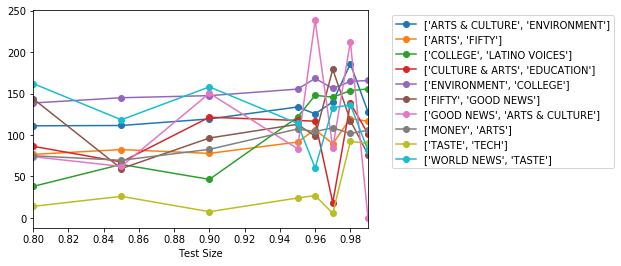

In [37]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
print("Coverage STD by Test Size")

plt = pd.pivot_table(data=df_test_size, 
               values="Coverage STD",
               columns="Labels",index="Test Size").plot(marker='o')
plt.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='upper right',bbox_to_anchor=(1.75, 1))

Average Coverage STD


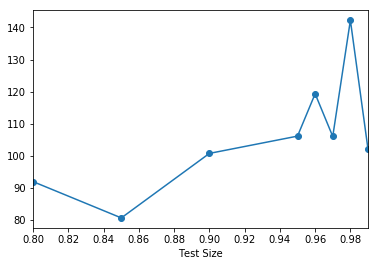

In [27]:
print("Average Coverage STD")
plt2 = df_average['Coverage STD'].plot(marker='o')
plt2.xaxis.set_major_locator(MaxNLocator(integer=True))

Coverage Percentage by Test Size


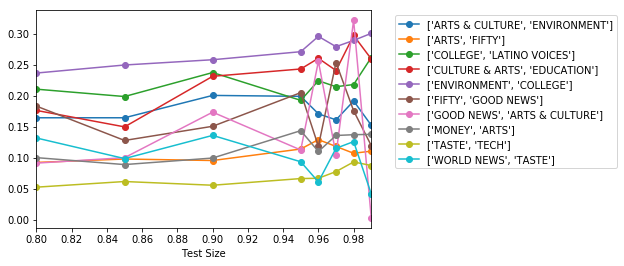

In [36]:
print("Coverage Percentage by Test Size")
plt3 = pd.pivot_table(data=df_test_size, 
               values="Coverage Percentage",
               columns="Labels",index="Test Size").plot(marker='o')
plt3.xaxis.set_major_locator(MaxNLocator(integer=True))
plt3.legend(loc='upper right',bbox_to_anchor=(1.75, 1))

Average Coverage Percentage


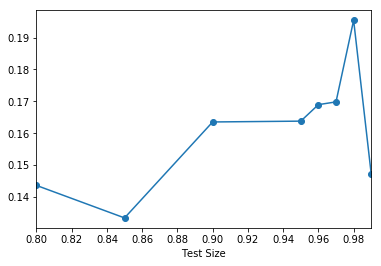

In [29]:
print("Average Coverage Percentage")
plt4 = df_average['Coverage Percentage'].plot(marker='o')
plt4.xaxis.set_major_locator(MaxNLocator(integer=True))

Correct Percentage by Test Size


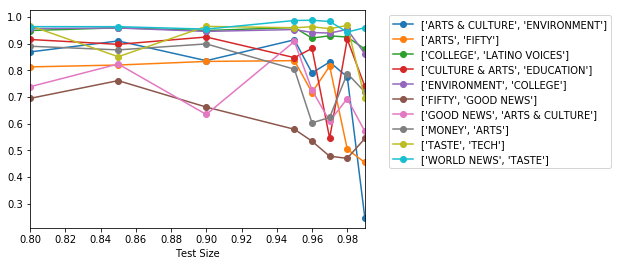

In [35]:
print("Correct Percentage by Test Size")
plt5 = pd.pivot_table(data=df_test_size, 
               values="Correct Percentage",
               columns="Labels",index="Test Size").plot(marker='o')
plt5.xaxis.set_major_locator(MaxNLocator(integer=True))
plt5.legend(loc='upper right',bbox_to_anchor=(1.75, 1))

Average Coverage Percentage


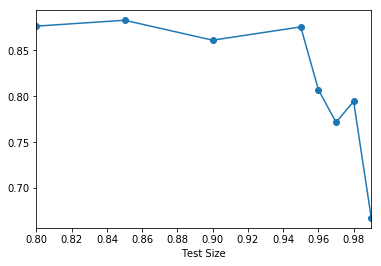

In [31]:
print("Average Correct Percentage")
plt6 = df_average['Correct Percentage'].plot(marker='o')
plt6.xaxis.set_major_locator(MaxNLocator(integer=True))

In [26]:
# df_test_size.to_pickle("/Users/yayan/Desktop/df_test_size_4_good.pkl")

In [27]:
# import pickle


# with open('/Users/yayan/Desktop/df_test_size_4_good.pkl', 'rb') as f:
#     data = pickle.load(f)